<a href="https://colab.research.google.com/github/Richa-yadav/RecommendationSystem/blob/main/RecommendationSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer #Import TfIdfVectorizer from scikit-learn
from nltk.tokenize import RegexpTokenizer
import re
import string
import random
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
%matplotlib inline

In [33]:
# Loading the my data
my_data = pd.read_csv('/content/Assignment - ML - Supporting Data (1).csv', low_memory=False)
#Print the first two rows
my_data.head(2)

,item_id,tags,hashtags,interacted,interactions
0,64253c1f8b8de00a9072b3a6,Topwear | Men T-Shirts | white | printed | reg...,#tshirt #topwear #menswear #gandhinagar #ludhiana,No,0
1,6423c06e9ef5a81769053d77,Topwear | Men T-Shirts | maroon | cotton | pri...,#tshirt #topwear #menswear #gandhinagar #ludhiana,No,0


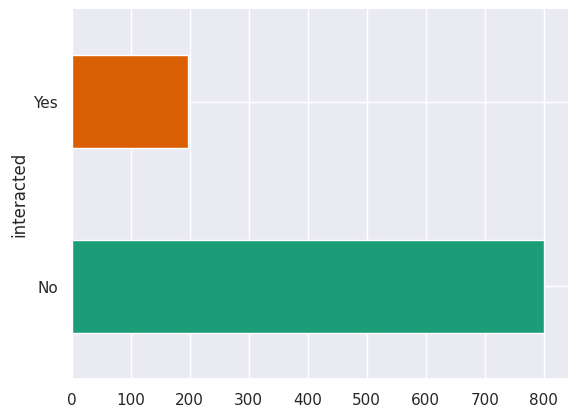

In [34]:
# @title interacted

from matplotlib import pyplot as plt
import seaborn as sns
my_data.groupby('interacted').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

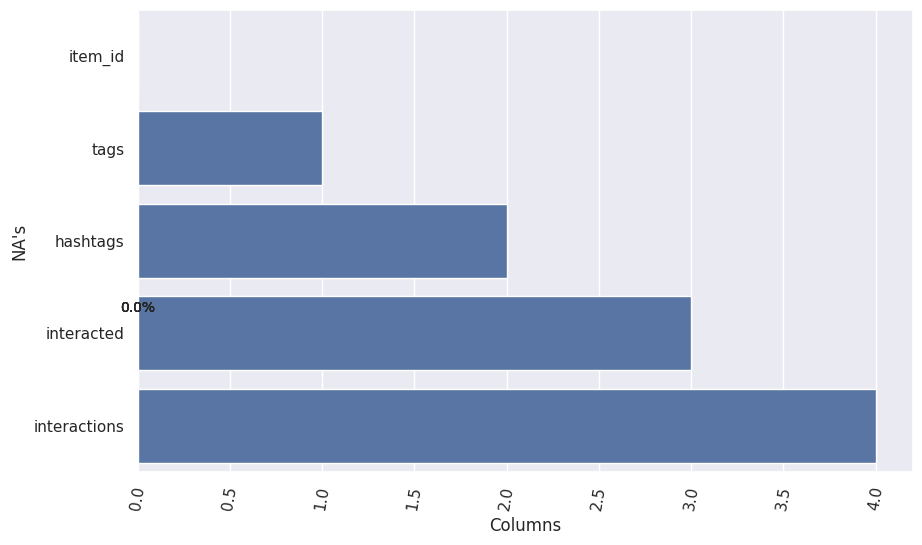

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
x = my_data.columns
y = my_data.isnull().sum()
plt.figure(figsize=(10,6))
sns.set()
sns.barplot(x)
ax = plt.gca()
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x(),
            height + 2,
            str(100*round(int(height)/my_data.shape[0], 3)) +"%",
            fontsize=10, ha='center', va='bottom')
ax.set_xlabel("Columns")
ax.set_ylabel("NA's")
plt.xticks(rotation=80)
plt.show()

In [36]:

# Data Wrangling
def preprocess_tags(tags):
    return tags.replace("|",",")

def preprocess_hashtags(hashhtags):
    return hashhtags.replace("\#",",")

# Apply preprocessing
my_data['cleaned_tags'] = my_data['tags'].apply(preprocess_tags)
my_data['cleaned_hashtags'] = my_data['hashtags'].str.slice_replace(0,1, '')

In [37]:
# Data Cleaning and Tuning
# Drop unnecessary columns
my_data = my_data.drop(['tags', 'hashtags'], axis=1)

# Handle missing values if any
my_data = my_data.dropna()

In [38]:
# Combine text features
my_data['combined_text'] = my_data['cleaned_tags'] + my_data['cleaned_hashtags']

# EDA (Exploratory Data Analysis)
# Show some basic statistics
print("Basic Statistics:")
print(my_data.describe())


Basic Statistics:
       interactions
count    997.000000
mean       0.658977
std        2.318091
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       25.000000


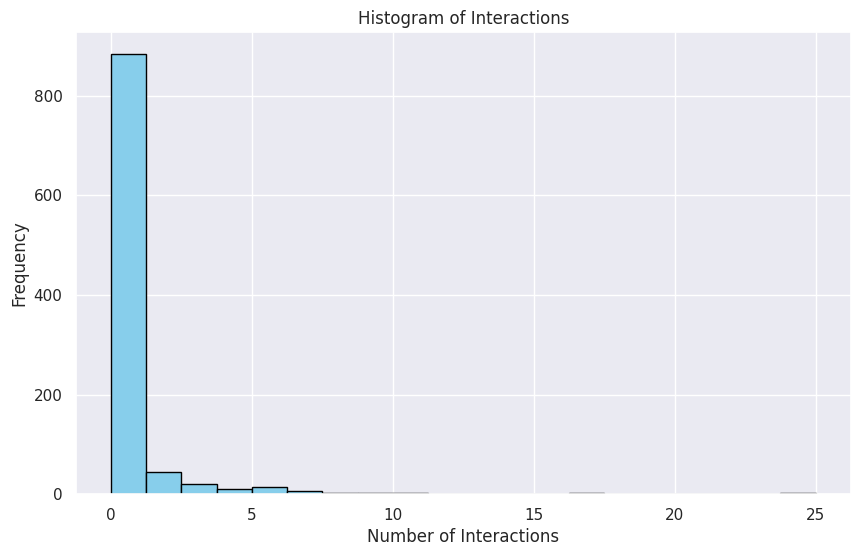

In [39]:

# Show a histogram of the number of interactions
plt.figure(figsize=(10, 6))
plt.hist(my_data['interactions'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Interactions')
plt.xlabel('Number of Interactions')
plt.ylabel('Frequency')
plt.show()

In [40]:
df_shop= my_data[['item_id','combined_text','interactions']]
df_shop.head()

,item_id,combined_text,interactions
0,64253c1f8b8de00a9072b3a6,"Topwear , Men T-Shirts , white , printed , reg...",0
1,6423c06e9ef5a81769053d77,"Topwear , Men T-Shirts , maroon , cotton , pri...",0
2,6424f5cd3a36c8270f258de8,"Women Topwear , pink , regular , casual , 3/4 ...",0
3,64251ffe9ef5a8176905defe,"Indian & Fusionwear , Kurtis , green , festive...",0
4,6425ac9d6fea7019f37f03cf,"Indian & Fusionwear , Kurtis , yellow , casual...",0


In [41]:
# Function for removing NonAscii characters in the description column
def _removeNonAscii(s):
    return "".join(i for i in s if  ord(i)<128)

# Function for converting into lower case
def make_lower_case(text):
    return text.lower()
# Function for removing punctuation
def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

In [42]:
df_shop['combined_text']=df_shop['combined_text'].apply(_removeNonAscii).apply(make_lower_case).apply(remove_punctuation)

<ipython-input-42-d1ba8dc382fb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_shop['combined_text']=df_shop['combined_text'].apply(_removeNonAscii).apply(make_lower_case).apply(remove_punctuation)


In [43]:
df_shop.head()

,item_id,combined_text,interactions
0,64253c1f8b8de00a9072b3a6,topwear men t shirts white printed regular cas...,0
1,6423c06e9ef5a81769053d77,topwear men t shirts maroon cotton printed reg...,0
2,6424f5cd3a36c8270f258de8,women topwear pink regular casual 3 4 sleeve r...,0
3,64251ffe9ef5a8176905defe,indian fusionwear kurtis green festive roundne...,0
4,6425ac9d6fea7019f37f03cf,indian fusionwear kurtis yellow casual roundne...,0


In [44]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer
#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')
#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(df_shop['combined_text'])
#Output the shape of tfidf_matrix
tfidf_matrix.shape

(997, 645)

In [45]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = CountVectorizer()
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [46]:
cosine_sim

array([[1.        , 0.75268977, 0.09297791, ..., 0.0251559 , 0.03825796,
        0.21055992],
       [0.75268977, 1.        , 0.08059753, ..., 0.02180629, 0.03316376,
        0.18252303],
       [0.09297791, 0.08059753, 1.        , ..., 0.        , 0.        ,
        0.07350365],
       ...,
       [0.0251559 , 0.02180629, 0.        , ..., 1.        , 0.11018963,
        0.01313601],
       [0.03825796, 0.03316376, 0.        , ..., 0.11018963, 1.        ,
        0.02430435],
       [0.21055992, 0.18252303, 0.07350365, ..., 0.01313601, 0.02430435,
        1.        ]])

In [47]:
idx =df_shop[df_shop['item_id']=='63a65a291d71aed7ecf61951'].index[0]

idx

915

In [48]:
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
top_items = sim_scores[1:5]
top_items_ids = [i[0] for i in top_items]

In [49]:
df_shop.loc[top_items_ids, 'item_id']

988    62ccfd78e90d251f6325756f
952    62ccfdbee90d251f632575d7
983    633dd32531c40dee51addc2d
996    62d7cc1fe90d251f6327b67c
Name: item_id, dtype: object

In [50]:
def recommend_items(item_id, cosine_sim_matrix, data):
    idx = data[data['item_id'] == item_id].index[0]
    sim_scores = list(enumerate(cosine_sim_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    top_items = sim_scores[1:6]
    top_items_ids = [i[0] for i in top_items]
    return data.loc[top_items_ids, 'item_id']

In [51]:
item_id_to_recommend = '63678da8f5954554dc53492b'
recommended_items = recommend_items(item_id_to_recommend, cosine_sim, df_shop)
recommended_items

921    638cfde5ce06fcdba0c90d50
817    640742e69b69e14cb4c12056
927    637c7463ce06fcdba0af2eae
820    63aef4b03444086d9c66fc21
822    6386fe63ce06fcdba0c132c7
Name: item_id, dtype: object

In [52]:
vectorizer = CountVectorizer()
item_matrix = vectorizer.fit_transform(df_shop['combined_text'])
from sklearn.neighbors import NearestNeighbors
knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
knn_model.fit(item_matrix)

# Recommend items based on user interactions using KNN
def recommend_items_knn(item_id, knn_model, data, vectorizer, k=5):
    idx = data[data['item_id'] == item_id].index[0]
    item_vector = vectorizer.transform([data.loc[idx, 'combined_text']])

    # Find the k nearest neighbors
    _, indices = knn_model.kneighbors(item_vector, n_neighbors=k+1)  # +1 to exclude the item itself

    # Get the item IDs of the top items
    top_items_ids = [data.loc[i, 'item_id'] for i in indices.flatten() if i != idx]

    return top_items_ids

# Example usage with KNN
item_id_to_recommend ='63678da8f5954554dc53492b'
recommended_items_knn = recommend_items_knn(item_id_to_recommend, knn_model, df_shop, vectorizer)


In [53]:
recommended_items_knn

['63aef4c53444086d9c66fc88',
 '63aef4b63444086d9c66fc4a',
 '6386fe63ce06fcdba0c132c7',
 '63031d05eb900cecc2c0d3f6',
 '638d0037ce06fcdba0c91092',
 '63678da4f5954554dc53491e']